# Use wateRinfo package to understand eel behaviour in the Scheldt river

## Introduction

The [Fish acoustic receiver network](http://lifewatch.be/en/fish-acoustic-receiver-network) is a Lifewatch supported infrastructure to track the distribution, movements and habitat use of migratory fish. Among other species, we tag and study eels to get data-based knowledge about their migration behaviour. Using this information we can propose effective policy measures to support this criticially endangered species.

Interested in the fascinating live of the eel and eager to understand what we're talking about when mentioning `transmitters` and `receivers`? Check out the animated video starring affiliated Phd student Pieterjan Verhelst:

[![Tagging research on eel in Belgium](https://img.youtube.com/vi/7YQVgl3QPyY/0.jpg)](https://www.youtube.com/watch?v=7YQVgl3QPyY)

We received an interested subset of the fish tracking data from Pieterjan about two eels. In this blog post, we'll do some explorative data analysis and show a research application of the [wateRinfo R package](https://inbo.github.io/wateRinfo/) we developed last year. 

## Eel tracking data

For now, let's start with the tracking data of the eels itself and do a quick check on the favorite places to hang out in the Scheldt estuary of two of our tagged eels.

In [21]:
# HIDE CELL
library(tidyverse)
library(lubridate)
library(leaflet)

In [4]:
# HIDE CELL
eels <- read_csv("..//files//eels.csv", col_types = cols())

The eel tracking data as received provides the residence time intervals between the `Arrival` and `Departure` of an eel with a `Transmitter` at a certain `Receiver` station. Each `Receiver` station does have a `latitude`, `longitude` and a `station` name:

In [5]:
# HIDE CELL
head(eels)

Date,Transmitter,Receiver,latitude,longitude,station,Arrival,Departure,Detections,residencetime
2016-10-11,A69-1601-52622,VR2W-112287,51.00588,3.77876,s-2,2016-10-11 17:41:00,2016-10-11 18:14:00,42,1980
2016-10-11,A69-1601-52622,VR2W-112297,51.00164,3.85695,s-Wetteren,2016-10-11 20:08:00,2016-10-11 20:25:00,10,1020
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 03:06:00,2016-10-12 10:15:00,175,25740
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 14:50:00,2016-10-12 23:11:00,185,30060
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 15:34:00,2016-10-13 19:22:00,70,13680
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 03:10:00,2016-10-13 11:12:00,121,28920


For each interval we got the number of raw detections of the `Receiver` for each `Transmitter` and the derived `residencetime` of the `Transmitter`, i.e. eel. As such, we can calculate the eels *favourite place to hang out* by calculating the total residence time around each receiver.

On a map, this looks like:

In [196]:
# HIDE CELL
residence <- eels %>% 
    group_by(Receiver, latitude, longitude, Transmitter) %>%
    summarise(total_residence = sum(residencetime))

In [214]:
# HIDE CELL
tag_colors <- colorFactor(c("#e66101", "#5e3c99"), eels$Transmitter)

m <- leaflet(data = residence, width = 600, height = 400) %>%
  addTiles() %>%  
  addCircleMarkers(~longitude, ~latitude, popup = ~Receiver, fillColor = ~tag_colors(Transmitter),
                   radius = ~total_residence/3600, stroke=FALSE, fillOpacity = 0.6) %>%
  addLegend(values = ~Transmitter, pal = tag_colors)
m

HTML widgets cannot be represented in plain text (need html)

Apparently, the eel carrying transmitter `A69-1601-52622` likes to be around Hamme and a section between Wetteren and Wichelen, whereas eel `A69-1601-52644` more likes to swim around along the different sections of the Scheldt river.

Let's give both eels a more compelling name than the Transmitter code their carrying. So the eel with transmitter `A69-1601-52622` is officially named **Greg** and the eel with transmitter `A69-1601-52644` **Iljo**!

Nevertheless, we miss the temporal effect in the previous figure and we do not know *when* the eels were passing these receiever stations. Let's reconfigure the eel tracking data to see their route in the Scheldt river in time:

In [14]:
# HIDE CELL
distance_from_sea <- read_csv("../files/distance_from_sea.csv", col_types = cols())
eels <- eels %>%
    left_join(distance_from_sea, by = "station")

In [52]:
# HIDE CELL
station_municipality <- read_csv("../files/link_station_municipality.csv", col_types = cols())
station_municipality <- station_municipality %>% 
    left_join(eels %>% select(station, distance_to_refence_station) %>% 
              distinct(), by = "station")

In [16]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=6)

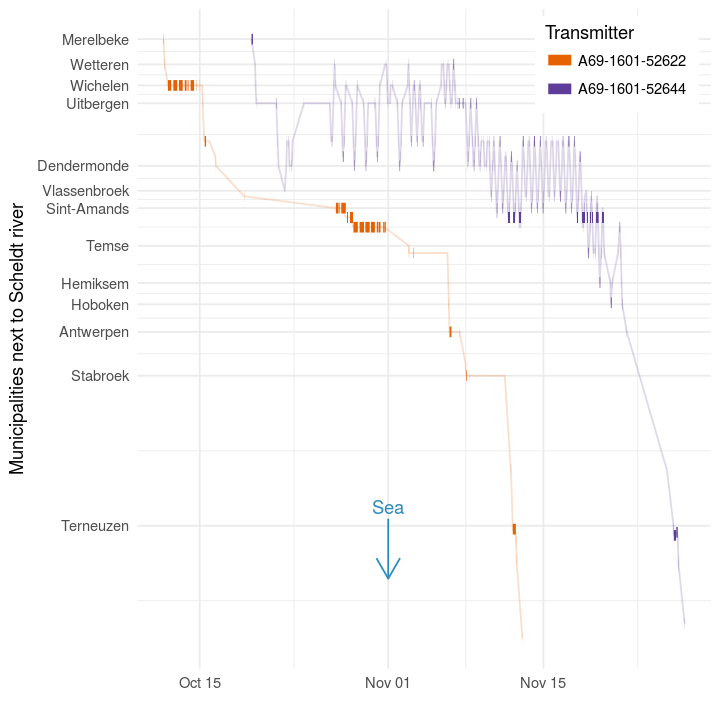

In [17]:
# HIDE CELL
ggplot(eels, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, 
                 yend = distance_to_refence_station,
                 color = Transmitter)) +
    geom_segment(size = 3) + xlab("") + ylab("") +
    geom_line(data = eels, aes(x = Arrival, y = distance_to_refence_station), 
              alpha = 0.2, size = 0.5) +
    scale_y_continuous("Municipalities next to Scheldt river", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    scale_color_manual(values = c("#e66101", "#5e3c99"), guide = guide_legend()) +
    annotate("text", x = as_datetime("2016-11-01"),
             y = max(eels$distance_to_refence_station) * 0.22, 
             colour = "#2b8cbe", label = "Sea") +
    annotate("segment", x = as_datetime("2016-11-01"), xend = as_datetime("2016-11-01"),
             y = max(eels$distance_to_refence_station) * 0.2, 
             yend = max(eels$distance_to_refence_station) * 0.1, 
                 arrow = arrow(length = unit(0.5, "cm")), color = "#2b8cbe") +
    theme_minimal() +
    theme(legend.position = c(.98, .99),
          legend.justification = c("right", "top"),
          legend.box.just = "right",
          legend.margin = margin(6, 6, 6, 6),
          legend.background =  element_rect(fill="white", color = "transparent"))

For both eels, we picked up the signal around Ghent/Merelbeke and they stay for a while in the Scheldt river before migration towards the sea. Once left, they start their long journey towards the Saragassos Sea. However, both eel clearly behave differently while moving towards the sea. 

As was already seen in the map representation, according to this visualisation Greg is residential for longer periods on a few specific places, whereas Iljo travels around much more along the river section between Temse and Merelbeke.

The periodic movement pattern of Iljo during the second half of november 2016 is of particular interest, as it seems to correspond to a tidal frequency. It would be interesting to compare the movement pattern with real water level data from the Scheldt river...  that's what the wateRinfo package is all about!

**Note:**
* To represent the data along a straight line (y-axis), we calculated the distances from each station to a reference station  close to the sea (`ws-DL7`) .  As this is the distance along the Scheld river, we used a `costDistance` function. Interested? See [this notebook ADD LINK](ADD LINK) for the details of the derivation.

### Tidal data from Waterinfo

[Waterinfo.be](http://waterinfo.be), management by the Flemisch Environmental agency (VMM) and the Hydraulics Lab (WL), is a great source for a wide set of abiotic variables. The water height of the Scheldt river is among these variables, providing detailed information of [tidal behaviour](https://www.waterinfo.be/default.aspx?path=NL/Thema/Getij_Actueel). 

Still, downloading the data from the website is both tedious (too much clicking) and not so repeatable for future analysie. The goal of our [wateRinfo package](https://github.com/inbo/wateRinfo) is to facilitate access to the variety of data by providing an R-interface to download time series data. The check for tidal/waterheight data is an ideal example.

For installation instructions, see [the Github page](https://github.com/INBO/waterinfo). As wateRinfo is not registered on CRAN, you will need the `devtools` package to install the wateRinfo package. Once installed, load the library:

In [41]:
library(wateRinfo)

As water levels in the Scheldt river are not among their core-variables to directly derive data, we'll use the [tidal stations overview](https://github.com/inbo/wateRinfo/files/1483458/tij_all_identifiers.txt) as currently discussed on the wateRinfo [GitHub Issues](https://github.com/inbo/wateRinfo/issues/11#issuecomment-345339779).  

This list of station identifiers is precompiled to derive all tidal VMM station timeseries:

In [28]:
# HIDE CELL
ts_id_tide <- read_csv("../files/scheldt_tide_waterinfo_identifiers.csv", col_types = cols())

In [29]:
head(ts_id_tide)

ID,station_no,ts_id,ts_name,parametertype_name,stationparameter_name,station_id,station_latitude,station_longitude,station_name,dataprovider,dataowner,Portal_Bekken
1,bnt03a-1074,3046929,bnt03aDUFF.W_r.KK.HWLW.tpk,h,W,312092,51.10914,4.530167,Duffel-sluis tij,MOW-HIC,HIC,Netebekken
2,bnt03a-1074,2803590,bnt03aDUFF.W_r,h,W,312092,51.10914,4.530167,Duffel-sluis tij,MOW-HIC,HIC,Netebekken
3,bnt03a-1074,2803817,bnt03aDUFF.W_t6.LW.base,h,W,312092,51.10914,4.530167,Duffel-sluis tij,MOW-HIC,HIC,Netebekken
4,bnt03a-1074,2803862,bnt03aDUFF.W_t6.1min.base,h,W,312092,51.10914,4.530167,Duffel-sluis tij,MOW-HIC,HIC,Netebekken
5,bnt03a-1074,2803822,bnt03aDUFF.W_t6.HWLW.base,h,W,312092,51.10914,4.530167,Duffel-sluis tij,MOW-HIC,HIC,Netebekken
6,bnt03a-1074,2803832,bnt03aDUFF.W_t6.10min.base,h,W,312092,51.10914,4.530167,Duffel-sluis tij,MOW-HIC,HIC,Netebekken


For each station, a set of variables is available, representing different frequencies (e.g. 1 min, 10 min) or certain derived variables, e.g. `HWLW` for the high and low water preaks as function of time. Although the `ts_name` description is not very intuitive (we just depend on the waterinfo.be infrastructure for this), it will do the job.

Let's have a quick look of the available stations, measuring water height under tidal influcence:

In [30]:
# HIDE CELL
m <- leaflet(data = ts_id_tide, width = 600, height = 400) %>%
  addTiles() %>%  
  addCircleMarkers(~station_longitude, ~station_latitude, popup = ~station_name, 
                   stroke=FALSE, fillOpacity = 0.6, fillColor = "#2b8cbe")
m

HTML widgets cannot be represented in plain text (need html)

To compare the eel positioning in the main channel of the Scheldt river, we exclude the stations in the Scheldt tributaries. Furthermore, we are only interested in the 10 min frequency time series for the moment:

In [23]:
non_scheldt_stations <- c("Walem tij/Rupel", "Duffel-sluis tij", "Lier Molbrug tij/Nete",
                           "Kessel tij/Grote Nete", "Emblem tij/Kleine Nete", 
                           "Mechelen Benedensluis tij/Dijle", "Mechelen Stuw Opwaarts tij/Dijle",
                           "Hombeek tij/Zenne", "Zemst tij/Zenne", "Gentbrugge tij/Zeeschelde",
                           "Waasmunster Manta tij/Durme")
ts_id_tide <- ts_id_tide %>%
    filter(grepl(".*10min.base", ts_name)) %>% # use 10min based time series
    filter(!station_name %in% non_scheldt_stations) # exclude nonte-scheldt stations

The [vignette](https://inbo.github.io/wateRinfo/articles/download_timeseries_batch.html) of the wateRinfo package provides the example code to download the data for multiple stations at once using the `tidyverse verbs`. We use a similar approach, but instead of manually providing the start (`from`) and end (`to`) data, we get these from the eels tracking data period:

In [26]:
start_tracking_period <- min(eels$Date)
end_tracking_period <- max(eels$Date)

tidal_data <- ts_id_tide %>%
    group_by(ts_id) %>%
    do(get_timeseries_tsid(.$ts_id,
                           from = start_tracking_period,
                           to = end_tracking_period,
                           datasource = 2)) %>%
    ungroup() %>%
    left_join(ts_id_tide, by = "ts_id")

In [384]:
# HIDE CELL
#tidal_data <- read_csv("../files/tidal_data.csv", col_types = cols())

In just a few lines R code, we downloaded for each of the tidal measurement stations the required time period of data. Make sure to check out the other tutorials as well on the [wateRinfo package website](https://inbo.github.io/wateRinfo/index.html)!

Checking the water level, expressed in meter TAW or mTAW, of Dendermonde in November 2016:

In [31]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=3)

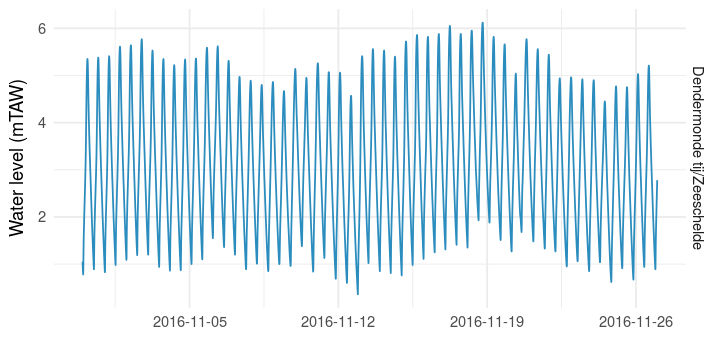

In [420]:
# HIDE CELL
tidal_plot <- tidal_data %>% 
    filter(station_name %in% c("Dendermonde tij/Zeeschelde")) %>%
    filter(Timestamp > "2016-10-31", Timestamp <= "2016-11-30") %>%
    ggplot() +
        geom_line(aes(x = Timestamp, y = Value), color = "#2b8cbe") +
        scale_x_datetime(date_labels = "%Y-%m-%d",
                         date_breaks = "7 days") +
        facet_grid(rows = vars(station_name)) +
        theme_minimal() + ylab("Water level (mTAW)") + xlab("")
tidal_plot

**Note:** TAW means [*Tweede Algemene Waterpassing*](https://nl.wikipedia.org/wiki/Tweede_Algemene_Waterpassing), a reference height for Belgium

To highlight the periods of low and high tide in the figure, we want to define the moment of low and high water level peaks. We could do this by extracting the local maxima of the tidal time series or by assuming a regular interval, but these low and high water level peaks are also available as data source from waterinfo.be, using the `HWLW` keyword in the `ts_name` time serie name. So, similar to downloading the 10 minutes time series, we can download only the peaks using the wateRinfo package.

Apply this to the Dendermonde station only:

In [34]:
ts_id_high_tide <- read_csv("../files/scheldt_tide_waterinfo_identifiers.csv", 
                            col_types = cols()) %>%
    filter(grepl(".HWLW.base", ts_name)) %>% # use HWLW based data
    filter(station_name == "Dendermonde tij/Zeeschelde")

# download the data similar to wateRinfo tutorial
peaks_tide <- ts_id_high_tide %>% group_by(ts_id) %>%
    do(get_timeseries_tsid(.$ts_id,
                           from = min(eels$Date),
                           to = max(eels$Date),
                           datasource = 2)) %>%
    ungroup() %>%
    left_join(ts_id_high_tide, by = "ts_id") %>%
    select(Timestamp, Value, station_no, station_name) %>%
    rename(tide_value = Value)
head(peaks_tide)

Timestamp,tide_value,station_no,station_name
2016-10-11 05:50:00,0.95,zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-11 11:23:00,4.43,zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-11 18:49:00,0.76,zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-12 00:21:00,4.71,zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-12 07:38:00,0.86,zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-12 12:58:00,4.56,zes47a-1066,Dendermonde tij/Zeeschelde


In [35]:
# HIDE CELL
# reformat to tidal start and end periods:
tide_periods <- peaks_tide %>%
    mutate(high_water = if_else(tide_value > 3, "end", "start")) %>%
    mutate(tide_id = sort(rep(seq(1, nrow(peaks_tide)/2 + 1), 2))[1:nrow(peaks_tide)]) %>%
    select(Timestamp, tide_id, high_water) %>%
    spread(key = high_water, value = Timestamp)
head(tide_periods)

tide_id,end,start
1,2016-10-11 11:23:00,2016-10-11 05:50:00
2,2016-10-12 00:21:00,2016-10-11 18:49:00
3,2016-10-12 12:58:00,2016-10-12 07:38:00
4,2016-10-13 01:32:00,2016-10-12 20:27:00
5,2016-10-13 14:05:00,2016-10-13 08:55:00
6,2016-10-14 02:35:00,2016-10-13 21:35:00


Using these periods, we can add a background color for each period between low and high tide:

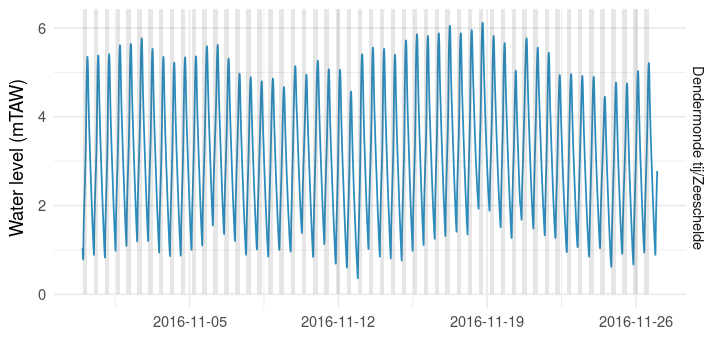

In [422]:
# HIDE CELL
tidal_plot + geom_rect(data = tide_periods %>% filter(start > "2016-10-31", end <= "2016-11-30"), 
              aes(xmin = start, xmax = end, ymin = 0, ymax = Inf), 
              alpha = 0.15)

Still, to represent the data of all the individual stations together with the tracks, we'll have to figure out an alternative way. One way to combine all tidal data in a single plot is to use its respective location in the Scheldt river and translate the water height in color intensity instead of lines.

In [36]:
# HIDE CELL
tidal_data <- tidal_data %>%
    left_join(distance_from_sea, by = c("station_name" = "station"))

In [37]:
# HIDE CELL
options(repr.plot.width=8, repr.plot.height=6)

Warning message:
“Removed 1 rows containing missing values (geom_segment).”

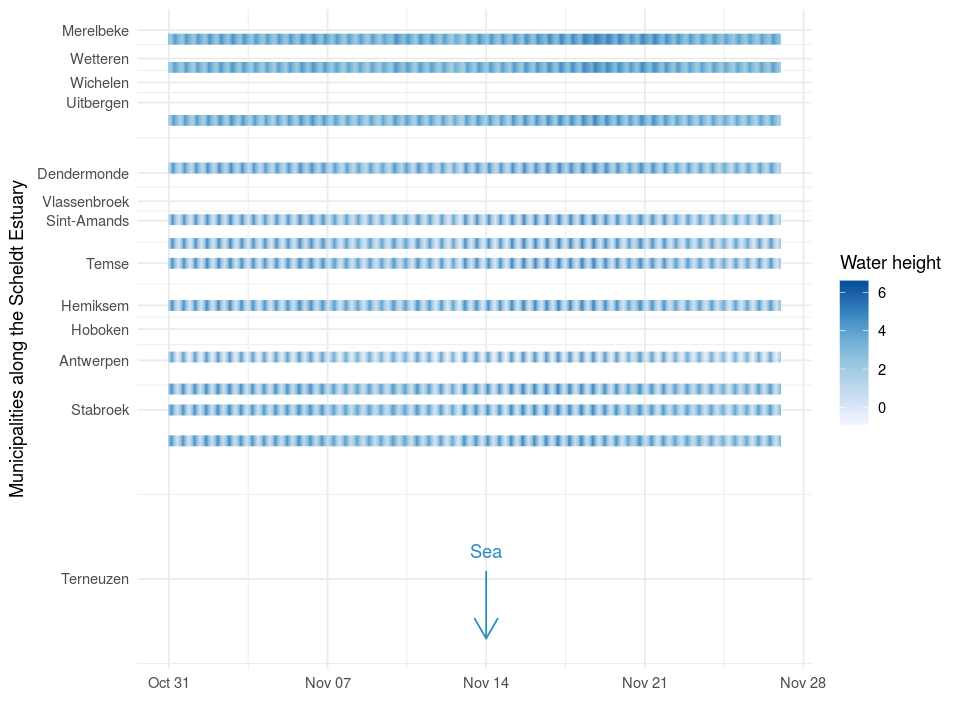

In [38]:
# HIDE CELL
tidal_plot <- ggplot() +
    geom_segment(data = tidal_data %>% filter(Timestamp > "2016-10-31", Timestamp <= "2016-11-30"), aes(x = Timestamp, xend = lag(Timestamp),
                 y = distance_to_refence_station, yend = distance_to_refence_station,
                 color = Value), size = 3) + 
    scale_color_distiller("Water height", type = "seq", palette = "Blues", direction = 1) +
    xlab("") + ylab("") +
    scale_y_continuous("Municipalities along the Scheldt Estuary", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    annotate("text", x = as_datetime("2016-11-14"),
             y = max(eels$distance_to_refence_station) * 0.23, 
             colour = "#2b8cbe", label = "Sea") +
    annotate("segment", x = as_datetime("2016-11-14"), xend = as_datetime("2016-11-14"),
             y = max(eels$distance_to_refence_station) * 0.2, 
             yend = max(eels$distance_to_refence_station) * 0.1, 
             arrow = arrow(length = unit(0.5, "cm")), color = "#2b8cbe") +
    theme_minimal()
tidal_plot

Each horizontal blue-shaded line is a time series just downloaded from waterinfo.be and the color intensity represents the water level as function of time. As such, we have all the bits and pieces together to combine the tidal data set with the tracking data of Iljo during the second half of november 2016.

## Is Iljo using the tide?

We combine the tracking data of Iljo and the water levels derived from the wateRinfo package to get more insight in the eel movement pattern and potential link with the water level data:

In [45]:
# HIDE CELL
start_moment <- "2016-11-14"
end_moment <- "2016-11-27"
transmitter_selected <- "A69-1601-52644"

In [46]:
# HIDE CELL
eels_subset <- eels %>% 
    filter(Departure >= start_moment, Arrival <= end_moment, 
           Transmitter == transmitter_selected)

tidal_data_subset <- tidal_data %>% 
    filter(Timestamp >= start_moment, 
           Timestamp <= end_moment)

tide_periods_subset <- tide_periods %>% 
    filter(start >= start_moment, 
           end <= end_moment)

In [53]:
# HIDE CELL
source('../files/plot_tidal_functions.R')

In [54]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=8)

Warning message:
“Removed 1 rows containing missing values (geom_segment).”

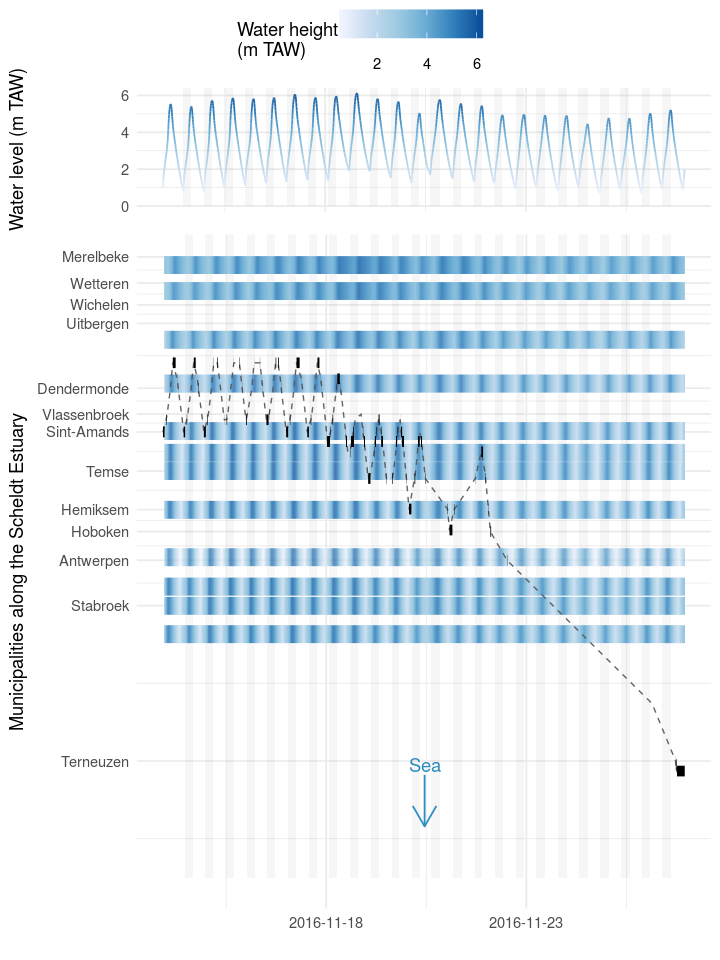

In [55]:
# HIDE CELL
# combine the eel tracking data with the tidal data representation
tidal_tracks <- plot_tidal_tracks(tidal_data_subset, eels_subset, 
                  tide_periods_subset, date_breaks = "5 days")

# create a water level plot of Dendermonde
tide_dendermonde <- plot_tide_with_background(tidal_data_subset %>% filter(station_name == "Dendermonde tij/Zeeschelde"), 
                                              tide_periods_subset, 
                                              date_breaks = "5 days") +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank()) # remove x-label elements

ggarrange(tide_dendermonde, tidal_tracks,  
          ncol = 1, nrow = 2, common.legend = TRUE,
          align = "v", heights = c(1, 5))

Hence, our eel is indeed *lazy* and following the tidal movement for a while before setting of to the sea. When the water comes inland from the sea (higher water levels), the eel follows the water stream upstream. When the water returns to the sea again to low tide, the eel moves againto the direction of the water.

ADD INFO FROM PJ? link to sciencitifc paper?!?

The previous figure inspired us to use the [ggridges package](https://cran.r-project.org/web/packages/ggridges/vignettes/introduction.html) to provide an alternative representation to the color intensity representation of the water levels. Instead, for each location a the water level is plotted as function of time. Applying this for a small subset of the data makes the tidal behaviour of the eel even more clear:

In [56]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=3)

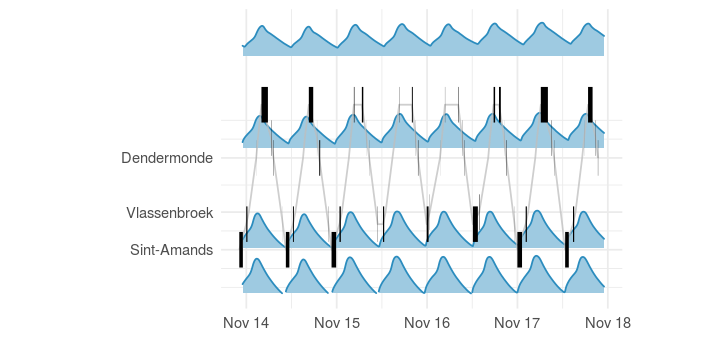

In [57]:
# HIDE CELL
library(ggridges)
ggridges_showcase(eels, tidal_data, station_municipality)

During high tide Iljo likes to be in Dendermonde (more upstream), whereas during low tide, moving downstream to Sint-Amands.

## And what about Gred?

So, Greg seemed to be much more resident oon chosen locations. But what if we confront its tracks with the tidal data as well?

In [58]:
# HIDE CELL
start_moment <- "2016-10-26"
end_moment <- "2016-11-07"

eels %>% filter(Departure >= start_moment, Arrival <= end_moment,
                Transmitter == "A69-1601-52622") -> eels_subset
tidal_data %>% filter(Timestamp >= start_moment, Timestamp <= end_moment) -> tidal_data_subset

tide_periods_subset <- tide_periods %>% 
    filter(start >= start_moment, 
           end <= end_moment)

In [59]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=8)

Warning message:
“Removed 1 rows containing missing values (geom_segment).”

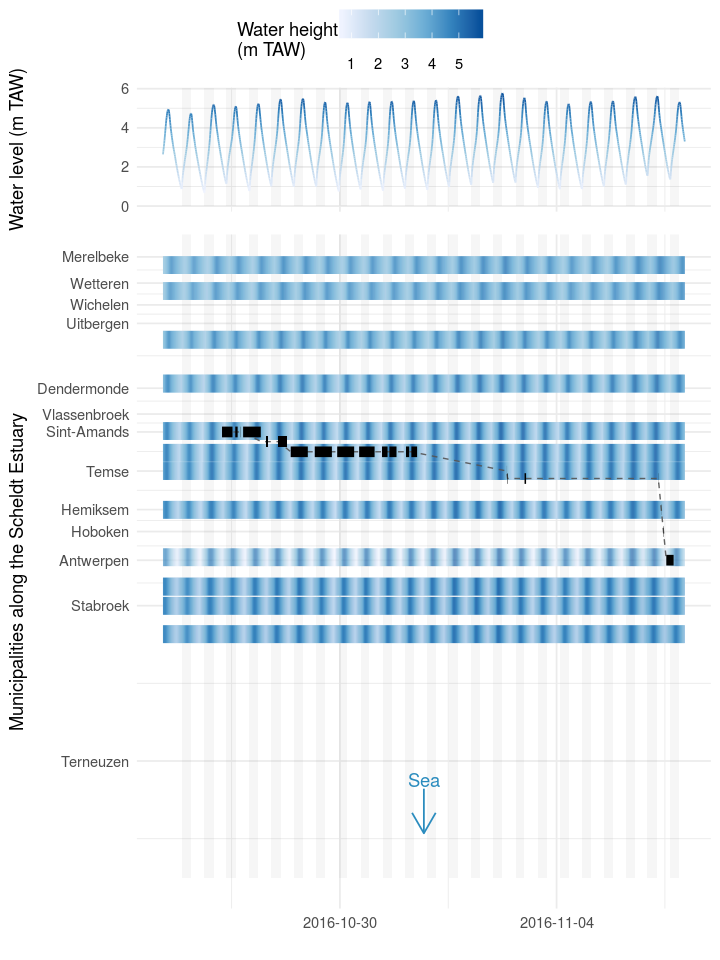

In [60]:
# HIDE CELL
# combine the eel tracking data with the tidal data representation
tidal_tracks <- plot_tidal_tracks(tidal_data_subset, eels_subset, 
                  tide_periods_subset, date_breaks = "5 days")

# create a water level plot of Dendermonde
tide_dendermonde <- plot_tide_with_background(tidal_data_subset %>% filter(station_name == "Dendermonde tij/Zeeschelde"), 
                                              tide_periods_subset, 
                                              date_breaks = "5 days") +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank()) # remove x-label elements

ggarrange(tide_dendermonde, tidal_tracks,  
          ncol = 1, nrow = 2, common.legend = TRUE,
          align = "v", heights = c(1, 5))

Actually, Greg is detected on the same location during high tide, but disappears for short periods during low tide. This indicates that Greg maybe exhibits the same pattern as Iljo after all! It could be that we are just missing the exact location of Greg during low tide periods because of the lack of a receiver at that particular location. In contrast to our [bird tracking data](https://www.gbif.org/dataset/83e20573-f7dd-4852-9159-21566e1e691e) we can not rely on a continous GPS logging for the fishtracking project, so we depend on the presence of receivers to actually measure the presence of the eel. 

Nevertheless, by linking the eels tracking data with the tidal data, we get more insight to demistify the behaviour of these very interesting species. 

**Acknowledgements:**

Thanks Greg and Iljo for being our study objects and hopefully you had a save journey towards the sargasso sea!